## Required data:
    <br> Apple stock (equity)
    <br> Market index (SP_500)
    <br> Risk-free rate (rf)
    <br> Liabilities   (L)

## Initializing python modules

In [1]:
import pandas_datareader.data as web
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as st
from math import exp
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

style.use('ggplot')

## Gathering data from various source

In [2]:
start = dt.datetime(2019, 1, 28)
end = dt.datetime(2020, 2, 7)

# Stocks from Yahoo finance
Apple = web.DataReader('AAPL', 'yahoo', start, end)['Adj Close']
SP_500 = web.DataReader('^GSPC', 'yahoo', start, end)['Adj Close']

#Liabilities
lis = []
for i in range(86):
    lis.append(170.328185)
for i in range(86):
    lis.append(274.610038) 
for i in range(88):
    lis.append(362.864864) 
liabilities = lis

# Risk-free rate ( One month US Treasury bill from  Fama and Kenneth R. French.)
rf = pd.read_csv('risk_free.csv')
rf = rf.tail(319).head(260)
rf = rf.RF

### Combining it all into one DataFrame

In [4]:
data = pd.DataFrame([Apple,SP_500]).T
data = data.iloc[:-1,:]
data.columns = ['Equity','sp_500']
data['Liabilities'] =lis
data['Risk_free'] = rf.to_list()
data = data[['Equity','Liabilities','Risk_free','sp_500']]
data

,Equity,Liabilities,Risk_free,sp_500
Date,,,,
2019-01-28,153.207047,170.328185,0.010,2643.850098
2019-01-29,151.619080,170.328185,0.010,2640.000000
2019-01-30,161.979935,170.328185,0.010,2681.050049
2019-01-31,163.146362,170.328185,0.010,2704.100098
2019-02-01,163.224792,170.328185,0.010,2706.530029
...,...,...,...,...
2020-01-31,307.943604,362.864864,0.006,3225.520020
2020-02-03,307.097900,362.864864,0.006,3248.919922
2020-02-04,317.236298,362.864864,0.006,3297.590088


# Required data for Iterative procedure:

In [5]:
df = data.drop('sp_500', axis = 1)
df['log_risk_free'] = np.log(1+df['Risk_free'])
df = df[['Equity','Liabilities', 'log_risk_free']]
df

,Equity,Liabilities,log_risk_free
Date,,,
2019-01-28,153.207047,170.328185,0.009950
2019-01-29,151.619080,170.328185,0.009950
2019-01-30,161.979935,170.328185,0.009950
2019-01-31,163.146362,170.328185,0.009950
2019-02-01,163.224792,170.328185,0.009950
...,...,...,...
2020-01-31,307.943604,362.864864,0.005982
2020-02-03,307.097900,362.864864,0.005982
2020-02-04,317.236298,362.864864,0.005982


### Initialising all required parameters and compute the book asset value ($A = E + D$) 

In [6]:
# initialising all parameters
debt = df.Liabilities
equity = df.Equity
rate = df.log_risk_free
T = 1
book_asset = equity + debt


### Next, we Compute the worth of the book asset value in the market using iterative procedure
- Here we compute the daily log return for each asset iteration using the formular below:
## <br>   ** $log\_returns = \log\left(\frac{Today's\ price}{Yesterday's\ price}\right)$**
<br>
- Next, we compute the asset's volatility for each iteration till we reach convergence using the formula below:
### <br> **$Annualized\_historical\_volatility = standard\_deviation(log\_returns)\times 260^{0.5}$**


## Iterative procedure

In [7]:

asset = book_asset.tolist()
SSE = 1                  # Initializing random sum squared difference value
asset_series = []        # Save the list of asset into the asset series list.
SSE_series = []          # Save error value from each iteration.
asset_vol_series = []    # Save the value of volatility from each iteration

number_iter = 10 

for i in range(number_iter):
    asset_series.append(asset)
    
    if SSE <= 1e-10:
        asset_vol_series.append(asset_vol)
        break
    else:
        
        log_returns = [np.log(asset[i+1]/asset[i]) for i in range(len(asset)-1)]  # Compute asset returns
        asset_vol = np.std(log_returns)*260**0.5    # Compute asset volatility
        
        asset_vol_series.append(asset_vol)

        d1 = (np.log(asset/debt)+(rate + (asset_vol**2)*0.5)*T)/asset_vol*np.sqrt(T)
        d2 = d1 - asset_vol*np.sqrt(T)
        df['d1'] = d1     
        df['d2'] = d2     # Save d1 and d2 dataframe containing (equity, debt,log_risk_free)

        current_asset = []     # List to hold all the daily asset value for the current iteration
 
        for record in df.to_records(index=False): # record = (equity, debt,log_risk_free, d1,d2)
        
            #Using Black_Scholes_Merton formula to compute currrent asset value in the market
            equity_,debt_,rate_,d1,d2 = record
            daily_asset = (equity_ + debt_*exp(-rate_*T)*st.norm.cdf(d2))/st.norm.cdf(d1)
            
            current_asset.append(daily_asset)
            
       
        SSE = np.sum([(i-j)**2  for i,j in zip(asset,current_asset)]) # Compute the sum squared difference
        SSE_series.append(SSE)
                
        asset = current_asset # Updating for next iteration

df_aseet_iter = pd.DataFrame(asset_series) # Put all asset iterations into one Dataframe

asset_iteration_df = df_aseet_iter.T
asset_iteration_df


,0,1,2,3,4,5,6,7
0,323.535232,321.283531,321.362182,321.356522,321.356958,321.356925,321.356927,321.356927
1,321.947265,319.672306,319.753397,319.747556,319.748006,319.747971,319.747974,319.747974
2,332.308120,330.169154,330.235492,330.230744,330.231109,330.231081,330.231084,330.231083
3,333.474547,331.348751,331.413593,331.408955,331.409313,331.409285,331.409287,331.409287
4,333.552977,331.428053,331.492796,331.488165,331.488522,331.488494,331.488496,331.488496
...,...,...,...,...,...,...,...,...
255,670.808468,667.114150,667.316129,667.301598,667.302717,667.302631,667.302637,667.302637
256,669.962764,666.252964,666.456470,666.441825,666.442952,666.442866,666.442872,666.442872
257,680.101162,676.566984,676.752859,676.739520,676.740548,676.740469,676.740475,676.740474
258,682.688045,679.195352,679.376957,679.363934,679.364937,679.364860,679.364866,679.364865


### The table above summarised the result from the iterative procedure. We reach convergence at 7 iteration.

##  Sum of Squared Difference Error

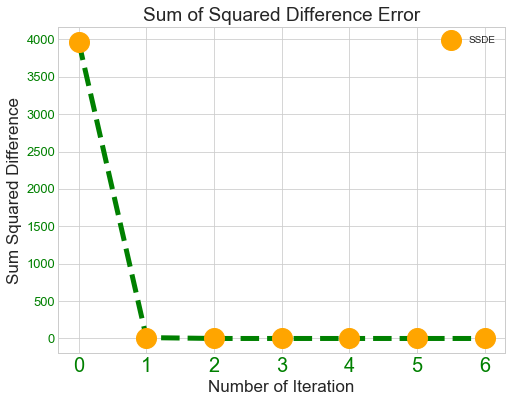

In [8]:
style.use('seaborn-whitegrid')
plt.figure(figsize = (8,6),frameon = False)
plt.plot(pd.DataFrame(SSE_series),linestyle='dashed', linewidth=5,color = 'green')
plt.plot(pd.DataFrame(SSE_series),'o', markersize=20, color = 'orange', label = 'SSDE')
plt.xticks(color = 'green',size = 20)
plt.yticks(color = 'green',size = 13)
plt.xlabel('Number of Iteration',size = 17)
plt.ylabel('Sum Squared Difference',size = 17)
plt.title('Sum of Squared Difference Error',size = 19)
plt.legend()
#plt.savefig('SSDE.png')
plt.show()

## Annualized Volatility

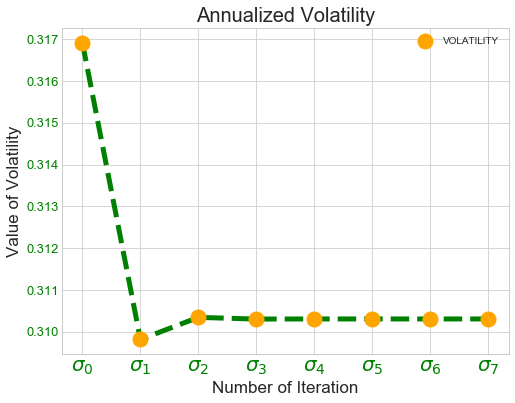

In [9]:
labels_ = ('$\sigma_{0}$', '$\sigma_{1}$', '$\sigma_{2}$', \
           '$\sigma_{3}$', '$\sigma_{4}$','$\sigma_{5}$',\
           '$\sigma_{6}$','$\sigma_{7}$')

plt.figure(figsize = (8,6))
plt.plot(asset_vol_series,linestyle='dashed', linewidth=5,color = 'green')
plt.plot(asset_vol_series,'o', markersize=15, label = 'VOLATILITY',color = 'orange')
plt.xticks(np.arange(8), labels_,color = 'green',size = 20)
plt.yticks(color = 'green',size = 13)
plt.xlabel('Number of Iteration',size = 17)
plt.ylabel('Value of Volatility', size = 17)
plt.title('Annualized Volatility',size = 20)
plt.legend(title_fontsize = 20)
#plt.savefig('volatility.png')
plt.show()

#   Using Capital Asset Pricing Model (CAPM) to estimate the drift rate $\mu$
### <br> First, we compute the returns and the excess returns on book asset and asset iterate
<br> (1) Daily returns on S&P_500, book asset and asset iterate is given by the formula below:  
## <br> ** $returns = \frac{Current \ price - Previous \ price}{Previous\ price}$**
<br> (2) Compute excess asset returns on S&P_500, book asset and asset iterate.  
## <br>** $excess$ $returns = returns - risk$ $free$ **


In [10]:
# This dataframe contained risk free rate, S&P500, asset, last iterated asset
df_drift = data[['Risk_free','sp_500']] 
df_drift['book_asset'] = asset_iteration_df[0].tolist()
df_drift['asset_iter'] = asset_iteration_df[7].tolist()


risk_free_rate = df_drift['Risk_free'].tolist() 
rf = [i for i in risk_free_rate]
rf.remove(0.01)  # Removing 0.01 from the rf in order to match the same size as the asset returns.

# S&P500
sp_500 = df_drift['sp_500'].tolist()
sp_500_ret = [(sp_500[i+1] - sp_500[i])/sp_500[i] for i in range(len(sp_500)-1)] # Compute daily returns for S&P500
sp_r1 = [i for i in sp_500_ret]
sp_excess_r1 = [i-j for i,j in zip(sp_r1,rf)]   # Compute excess return for S&P500
V_sp_excess_r1 = [i for i in sp_excess_r1]
V_sp_excess_r1.insert(0,np.nan) # Fill in nan value in order to match the size of assets in the dataframe below
sp_r1.insert(0,np.nan)    # Fill in nan value in order to match the size of S&p500 in the dataframe below

# Book asset
book_asset = df_drift['book_asset'].tolist()
book_asset_ret = [(book_asset[i+1] - book_asset[i])/book_asset[i] for i in range(len(book_asset)-1)]
ba_r2 = [i for i in book_asset_ret]
excess_ba_r2 = [i-j for i,j in zip(ba_r2,rf)]
V_excess_ba_r2 = [i for i in excess_ba_r2]
V_excess_ba_r2.insert(0,np.nan)
ba_r2.insert(0,np.nan)

# Asset Iterate
asset_iter = df_drift['asset_iter'].tolist()
asset_iter_ret = [(asset_iter[i+1] - asset_iter[i])/asset_iter[i] for i in range(len(asset_iter)-1)]
ait_r2 = [i for i in asset_iter_ret]
excess_ait_r2 = [i-j for i,j in zip(ait_r2,rf)]
V_excess_ait_r2 = [i for i in excess_ait_r2]
V_excess_ait_r2.insert(0,np.nan)
ait_r2.insert(0,np.nan)

# Dataframe 
df_drift['sp_500_returns'] = sp_r1
df_drift['book_asset_ret'] = ba_r2
df_drift['asset_iter_ret'] = ait_r2
df_drift['V_sp_excess_r1'] = V_sp_excess_r1
df_drift['V_excess_ba_r2'] = V_excess_ba_r2
df_drift['V_excess_ait_r2'] = V_excess_ait_r2
df_drift


C:\Users\vicky\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Risk_free,sp_500,book_asset,asset_iter,sp_500_returns,book_asset_ret,asset_iter_ret,V_sp_excess_r1,V_excess_ba_r2,V_excess_ait_r2
Date,,,,,,,,,,
2019-01-28,0.010,2643.850098,323.535232,321.356927,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-29,0.010,2640.000000,321.947265,319.747974,-0.001456,-0.004908,-0.005007,-0.011456,-0.014908,-0.015007
2019-01-30,0.010,2681.050049,332.308120,330.231083,0.015549,0.032182,0.032786,0.005549,0.022182,0.022786
2019-01-31,0.010,2704.100098,333.474547,331.409287,0.008597,0.003510,0.003568,-0.001403,-0.006490,-0.006432
2019-02-01,0.010,2706.530029,333.552977,331.488496,0.000899,0.000235,0.000239,-0.009101,-0.009765,-0.009761
...,...,...,...,...,...,...,...,...,...,...
2020-01-31,0.006,3225.520020,670.808468,667.302637,-0.017706,-0.020854,-0.021273,-0.023706,-0.026854,-0.027273
2020-02-03,0.006,3248.919922,669.962764,666.442872,0.007255,-0.001261,-0.001288,0.001255,-0.007261,-0.007288
2020-02-04,0.006,3297.590088,680.101162,676.740474,0.014980,0.015133,0.015452,0.008980,0.009133,0.009452


### <br> (3) Copy excess returns on S&P_500, book asset and asset iterate from the table above. 
## <br> ** $excess$ $returns = returns - risk$ $free$ **

In [11]:
excess_df = pd.DataFrame([sp_excess_r1,excess_ba_r2,excess_ait_r2]).T
excess_df.columns = ['excess_sp_500', 'excess_ba', 'excess_ait']
excess_df


,excess_sp_500,excess_ba,excess_ait
0,-0.011456,-0.014908,-0.015007
1,0.005549,0.022182,0.022786
2,-0.001403,-0.006490,-0.006432
3,-0.009101,-0.009765,-0.009761
4,-0.003224,0.003900,0.004117
...,...,...,...
254,-0.023706,-0.026854,-0.027273
255,0.001255,-0.007261,-0.007288
256,0.008980,0.009133,0.009452
257,0.005251,-0.002196,-0.002122


### Compute beta for book asset and asset iterate. 

# <br>(5) $Beta =$ $\frac{cov(excess_{sp\_500},\ excess_{asset})}{var(excess_{asset})}$

In [12]:
# Calculate Beta from book asset and market index (S&P500)
cov_sp_ba = excess_df[['excess_sp_500','excess_ba']].cov()
Beta_sp_ba = cov_sp_ba.loc['excess_sp_500','excess_ba']/excess_df[['excess_sp_500']].var()
Beta_sp_ba = Beta_sp_ba.values[0]

# Calculate Beta from asset iterate and market index (S&P500)
cov_sp_ait = excess_df[['excess_sp_500','excess_ait']].cov()
Beta_sp_ait = cov_sp_ait.loc['excess_sp_500','excess_ait']/excess_df[['excess_sp_500']].var()
Beta_sp_ait = Beta_sp_ait.values[0]
(Beta_sp_ba,Beta_sp_ait)

(0.18080404068545314, 0.21422011598874804)

### Market premium
## <br> (6) $Market$ $premium = E(return_{sp500})- risk$ $free$ $rate$

In [13]:
# We convert the average daily return to average anualised daily returns:
E_Rm = (np.mean(sp_500_ret) + 1)**259 - 1

# average annualised market risk premium is assumed :
market_primium = E_Rm - rf[-1]  
market_primium

0.2686491063105685

### Expected return on book asset and asset iterate
  
## <br> (7) ** $expected_{returns} = risk$ $free$ $rate + beta\times Market$ $primium $ **

In [14]:
#Expected return on book asset
expected_return_1 =  rf[-1] + (Beta_sp_ba * market_primium) 
#Expected return on asset iterate
expected_return_2 =  rf[-1] + (Beta_sp_ait*market_primium)

(expected_return_1,expected_return_2)

(0.05457284394748665, 0.06355004271412348)

### Drift rate for book asset and asset iterate
## <br> (8)   ** $Drift$ $rate = \ln(1 + expectd_{returns})$ **

In [15]:
# drift rate of book asset
drift_1 = np.log(1+expected_return_1 )
# drift rate of asset iterate
drift_2 = np.log(1+expected_return_2 )

(drift_1,drift_2)

(0.05313579768548698, 0.06161240928936037)

## Table to summarise result from CAPM model

In [16]:
capm_variable = {'At maturity 2020-02-06':['book asset', 'asset iterate'],
                 'Beta':[Beta_sp_ba,Beta_sp_ait],
                 'Expected return':[expected_return_1,expected_return_2],
                 'Drift rate': [drift_1,drift_2]}
pd.DataFrame(capm_variable)

,At maturity 2020-02-06,Beta,Expected return,Drift rate
0,book asset,0.180804,0.054573,0.053136
1,asset iterate,0.214220,0.063550,0.061612


### Computing the Actual Probability of default (APD) for book asset and asset iterate
<br> 	
 ## $P_{def} = N \left(- \frac{\ln\left(\frac{A_{T}}{L}\right)+ \left(\mu_{A} - \frac{\sigma_{A}}{2} \right)t}{\sigma_{A}\sqrt{t}} \right)$
	

In [17]:
debt_last = debt[259]   # Debt at maturity

# Book asset
asset_1 = asset_iteration_df[0][259]  #Book asset at maturity 
asset_1_vol = asset_vol_series[0]    #Book_asset's volatility at maturity 
mu_1 = drift_1    #Drift rate at maturity

# Probability of default for Book asset
PD = st.norm.cdf(-((np.log(asset_1/debt_last) + (mu_1 - (asset_1_vol**2)*0.5)*T)/asset_1_vol*np.sqrt(T)))

# Asset iterate
asset_iter = asset_iteration_df[7][259]   # Asset_iterate at maturity
asset_iter_vol = asset_vol_series[6]    # Asset_iterate's volatility at maturity
mu_2 = drift_2   # Drift rate at maturity

#probability of default for Asset iterate
PD_iter = st.norm.cdf(-((np.log(asset_iter/debt_last) + (mu_1 - (asset_iter_vol**2)*0.5)*T)/asset_iter_vol*np.sqrt(T)))

str(round(PD*100,2))+'%', str(round(PD_iter*100,2))+'%'

('2.17%', '1.99%')

In [18]:
PD_variables = {'At maturity 2020-02-06' :['Debt ($L_{T}$)', 
                                           'Asset ($A_{T}$)',
                                           'Volatility ($\sigma_{A}$)', 
                                           'Drift rate ($\mu_{A}$)',
                                           ' ',
                                           'Probability of default ($PD$)'
                                          ],
                'Book asset':[debt_last, asset_1, str(round(asset_1_vol,2)) +'%', str(round(mu_1*100,2)) + '%', ' ', str(round(PD*100,2)) + '%'],
                'Asset iterate':[debt_last, asset_iter, str(round(asset_iter_vol,2)) +'%', str(round(mu_2*100,2)) +'%',' ', str(round(PD_iter*100,2)) + '%']}
                                                            
pd.DataFrame(PD_variables)

,At maturity 2020-02-06,Book asset,Asset iterate
0,Debt ($L_{T}$),362.865,362.865
1,Asset ($A_{T}$),686.429,683.158
2,Volatility ($\sigma_{A}$),0.32%,0.31%
3,Drift rate ($\mu_{A}$),5.31%,6.16%
4,,,
5,Probability of default ($PD$),2.17%,1.99%


### Computing the Risk-Neutral Probability of default (RNPD)  for book asset and asset iterate
 <br>	
## 	$P_{def} = N \left(- \frac{\ln\left(\frac{A_{T}}{L}\right)+ \left(r - \frac{\sigma_{A}}{2} \right)t}{\sigma_{A}\sqrt{t}} \right)$
	

In [19]:
# RNPD for Book asset
RNPD = st.norm.cdf(-((np.log(asset_1/debt_last) + (rf[-1]  - (asset_1_vol**2)*0.5)*T)/asset_1_vol*np.sqrt(T)))

# RNPD for asset iterate 
RNPD_iter = st.norm.cdf(-((np.log(asset_iter/debt_last) + (rf[-1] - (asset_iter_vol**2)*0.5)*T)/asset_iter_vol*np.sqrt(T)))

str(round(RNPD*100,2))+'%', str(round(RNPD_iter*100,2))+'%'


('3.06%', '2.85%')

In [20]:
PD_variables = {'At maturity 2020-02-06' :['Debt ($L_{T}$)', 
                                           'Asset ($A_{T}$)',
                                           'Volatility ($\sigma_{A}$)', 
                                           'Risk-free rate ($Rf$)',
                                           ' ',
                                           'Risk-Neutral Probability of default ($RNPD$)'
                                          ],
                'Book asset':[debt_last, asset_1, str(round(asset_1_vol,2)) +'%', str(round(rf[-1]*100,2)) + '%', ' ', str(round(RNPD*100,2)) + '%'],
                'Asset iterate':[debt_last, asset_iter, str(round(asset_iter_vol,2)) +'%', str(round(rf[-1]*100,2)) +'%',' ', str(round(RNPD_iter*100,2)) + '%']}
                                                            
pd.DataFrame(PD_variables)

,At maturity 2020-02-06,Book asset,Asset iterate
0,Debt ($L_{T}$),362.865,362.865
1,Asset ($A_{T}$),686.429,683.158
2,Volatility ($\sigma_{A}$),0.32%,0.31%
3,Risk-free rate ($Rf$),0.6%,0.6%
4,,,
5,Risk-Neutral Probability of default ($RNPD$),3.06%,2.85%


## Relationship between drift rate and probability of default

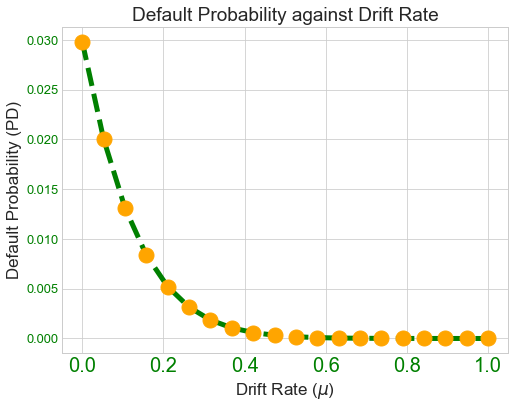

In [21]:
drifts = np.linspace(0,1,20)
rnpd = []
for drift in drifts:
    RNPD_iter = st.norm.cdf(-((np.log(asset_iter/debt_last) + (drift - (asset_iter_vol**2)*0.5)*T)/asset_iter_vol*np.sqrt(T)))
    rnpd.append(RNPD_iter)
    
# Visualization
plt.figure(figsize = (8,6),frameon = False)
plt.plot(drifts,rnpd,linestyle='dashed', linewidth=5,color = 'green')
plt.plot(drifts,rnpd,'o', markersize=15, color = 'orange', label = 'SSDE')
plt.xticks(color = 'green',size = 20)
plt.yticks(color = 'green',size = 13)
plt.xlabel('Drift Rate ($\mu$)',size = 17)
plt.ylabel('Default Probability (PD)',size = 17)
plt.title('Default Probability against Drift Rate',size = 19)
#plt.savefig('PDvsDrift.png')
plt.show()